# DNN Regression with Optuna Hyperparameter Tuning

In [35]:
#!pip install optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import optuna
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

## 1. Generate and Split Data

In [36]:
# Generate synthetic regression dataset
X, y = make_regression(n_samples=1200, n_features=10, noise=15.0, random_state=42)
y = y.reshape(-1, 1)

# Combine and save as single CSV
os.makedirs('./DATA', exist_ok=True)
full_data = np.hstack((X, y))
pd.DataFrame(full_data).to_csv('./DATA/regression_data.csv', index=False, header=False)

In [37]:
# Train-Valid-Test Split (60-20-20)
# Load from CSV
df = pd.read_csv('./DATA/regression_data.csv', header=None)
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test  = scaler_X.transform(X_test)
y_train = scaler_y.transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test  = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

In [38]:
# Define model class
class Regressor(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.net(x)

In [39]:
# Objective function for Optuna
def objective(trial):
    hidden1 = trial.suggest_int("hidden1", 32, 128)
    hidden2 = trial.suggest_int("hidden2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    model = Regressor(input_dim=10, hidden1=hidden1, hidden2=hidden2, dropout=dropout)
    criterion = nn.MSELoss()

    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(30):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid_tensor)
        val_loss = mean_squared_error(y_valid_tensor.numpy(), val_pred.numpy())
    return val_loss

In [40]:
# Run Optuna tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-08-03 14:33:08,256] A new study created in memory with name: no-name-e09903af-7507-4f04-b0f2-12f4f93c9782
[I 2025-08-03 14:33:08,687] Trial 0 finished with value: 0.6031204462051392 and parameters: {'hidden1': 38, 'hidden2': 29, 'dropout': 0.42691156450884993, 'lr': 0.0001362860604158359, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6031204462051392.
[I 2025-08-03 14:33:09,024] Trial 1 finished with value: 0.9752975106239319 and parameters: {'hidden1': 53, 'hidden2': 38, 'dropout': 0.18541586627449813, 'lr': 0.0003270994598461637, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6031204462051392.
[I 2025-08-03 14:33:09,759] Trial 2 finished with value: 0.010403867810964584 and parameters: {'hidden1': 66, 'hidden2': 18, 'dropout': 0.17473554925637558, 'lr': 0.0006146894401924952, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.010403867810964584.
[I 2025-08-03 14:33:10,044] Trial 3 finished with value: 0.95506590


✅ Final Test MSE: 0.0117


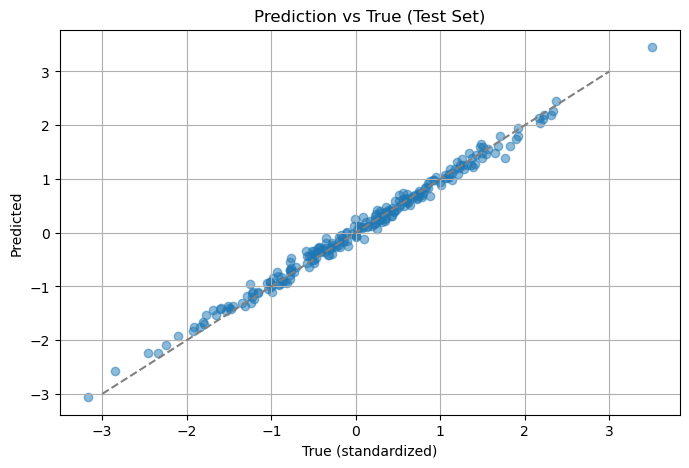

In [41]:
# Train best model on train + valid, then evaluate on test
best_params = study.best_trial.params
model_final = Regressor(
    input_dim=10,
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout=best_params["dropout"]
)
criterion = nn.MSELoss()
optimizer_cls = getattr(optim, best_params["optimizer"])
optimizer = optimizer_cls(model_final.parameters(), lr=best_params["lr"])

# combine train + valid
X_full = np.vstack([X_train, X_valid])
y_full = np.vstack([y_train, y_valid])
X_full_tensor = torch.tensor(X_full, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full, dtype=torch.float32)

full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Final training
for epoch in range(50):
    model_final.train()
    for xb, yb in full_loader:
        optimizer.zero_grad()
        pred = model_final(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

# Evaluation on test
model_final.eval()
with torch.no_grad():
    y_pred = model_final(X_test_tensor).numpy()
    y_true = y_test_tensor.numpy()
    test_mse = mean_squared_error(y_true, y_pred)
    print(f"\n✅ Final Test MSE: {test_mse:.4f}")

# Optional: plot prediction vs true
plt.figure(figsize=(8,5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("True (standardized)")
plt.ylabel("Predicted")
plt.title("Prediction vs True (Test Set)")
plt.grid(True)
plt.plot([-3, 3], [-3, 3], linestyle='--', color='gray')
plt.show()